In [59]:
from preprocessing.data_loader import load_and_process_data
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


df = load_and_process_data(remove_outliers=True, normalize=False, lab="all", verbose=False)
df['logrms'] = np.log1p(df['rms'])
df.insert(7, 'logrms', df.pop('logrms'))
df

,slowdelta,fastdelta,slowtheta,fasttheta,alpha,beta,rms,logrms,mouseID,lab,sleepstage,epoch,unique_id
0,0.286260,0.175425,0.207455,0.125388,0.108024,0.058404,0.338769,0.291750,1.0,1.0,3.0,1.0,1
1,0.238637,0.121246,0.174037,0.067707,0.070327,0.040197,0.248721,0.222120,1.0,1.0,3.0,2.0,1
2,0.121714,0.290182,0.313687,0.087330,0.092042,0.071340,0.228859,0.206086,1.0,1.0,3.0,3.0,1
3,0.090216,0.104930,0.454057,0.256769,0.107563,0.061333,0.211976,0.192252,1.0,1.0,1.0,6.0,1
6,0.077062,0.133382,0.458816,0.114722,0.097439,0.039885,0.228008,0.205394,1.0,1.0,1.0,9.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1958286,0.139606,0.095954,0.214060,0.121142,0.201720,0.156274,0.123541,0.116485,16.0,5.0,3.0,10794.0,150
1958287,0.113887,0.122214,0.271802,0.143455,0.170195,0.169966,0.125525,0.118250,16.0,5.0,3.0,10795.0,150
1958288,0.096449,0.254481,0.149651,0.123115,0.101740,0.076557,0.097413,0.092956,16.0,5.0,3.0,10796.0,150
1958289,0.065317,0.313154,0.243949,0.100223,0.075370,0.135688,0.077541,0.074681,16.0,5.0,3.0,10797.0,150


In [60]:
# only keep ["slowdelta", "fastdelta", "slowtheta", "fasttheta", "alpha", "beta", "rms", "sleepstage"]
df = df.sort_values("sleepstage", kind="mergesort")
y2 = df['lab'].to_numpy()
X = df.drop(columns=['mouseID', 'lab', 'sleepstage', 'epoch', 'unique_id', 'rms'])
display(X)

y = df['sleepstage']
X = X.to_numpy()
y = y.to_numpy()
X = X.T

,slowdelta,fastdelta,slowtheta,fasttheta,alpha,beta,logrms
3,0.090216,0.104930,0.454057,0.256769,0.107563,0.061333,0.192252
6,0.077062,0.133382,0.458816,0.114722,0.097439,0.039885,0.205394
9,0.064137,0.093940,0.418917,0.246367,0.164479,0.100692,0.221801
79,0.158111,0.053875,0.449323,0.100933,0.067702,0.104919,0.293663
80,0.124941,0.155744,0.393029,0.093557,0.150521,0.064012,0.191943
...,...,...,...,...,...,...,...
1958286,0.139606,0.095954,0.214060,0.121142,0.201720,0.156274,0.116485
1958287,0.113887,0.122214,0.271802,0.143455,0.170195,0.169966,0.118250
1958288,0.096449,0.254481,0.149651,0.123115,0.101740,0.076557,0.092956
1958289,0.065317,0.313154,0.243949,0.100223,0.075370,0.135688,0.074681


In [61]:
n = 10000 * 3
idx = np.random.choice(len(y), n, replace=False)

sorted_idx = np.sort(idx)
X = X[:, sorted_idx]
y = (y[sorted_idx]).astype(int)
y2 = (y2[sorted_idx]).astype(int)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = torch.tensor(X).to(device)

In [62]:
from tqdm import tqdm
from CGD import AA_model, AA_trainer

K_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]

C_lists = [[] for _ in range(len(K_list))]
S_lists = [[] for _ in range(len(K_list))]
loss_lists = [[] for _ in range(len(K_list))]

# class_weights is 1/number of samples in each class
class_labels = torch.tensor(y, dtype=torch.long).to(device)
unique_labels = torch.unique(class_labels)

# Calculate class weights using PyTorch operations
class_weights = torch.tensor([1 / torch.sum(class_labels == i).item() for i in unique_labels]).to(device)
class_weights = class_weights / torch.sum(class_weights) * 10

# Expand class_weights to match each sample
sample_weights = class_weights[class_labels - 1]

for i, K in enumerate(tqdm(K_list)):
    for _ in range(5):
        model = AA_model.AA(X=data, num_comp=K, class_weights=sample_weights, noise_term=True, model='AA', verbose=False)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        loss,_ = AA_trainer.Optimizationloop(model=model, optimizer=optimizer, max_iter=3000, tol=1e-6, disable_output=True)
        C, S = model.get_model_params()
        C_lists[i].append(C)
        S_lists[i].append(S)
        loss_lists[i].append(loss)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [10:04<00:00, 67.19s/it]


In [65]:
# save loss_lists in data/loss_plots
import os
import numpy as np
import pickle
os.makedirs('plot_data/loss_plots', exist_ok=True)
with open('plot_data/loss_plots/loss_lists_a1al_5.pkl', 'wb') as f:
    pickle.dump(loss_lists, f)

In [55]:
import os
import numpy as np
import pickle

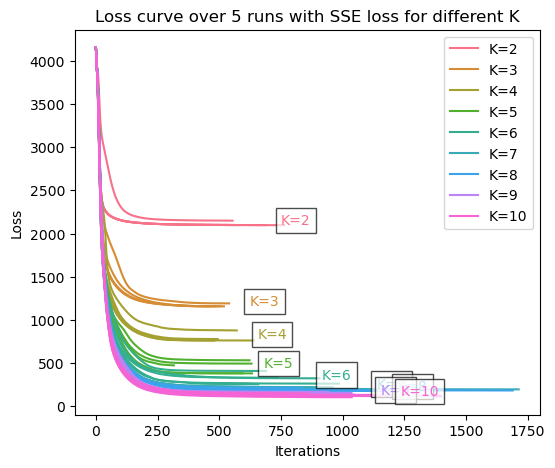

In [67]:
# use colors from seaborn
plt.figure(figsize=(6, 5))
K_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
colors = sns.color_palette("husl", len(K_list))

name = '31an'

with open(f'plot_data/loss_plots/loss_lists_{name}.pkl', 'rb') as f:
    loss_lists = pickle.load(f)

for i, K in enumerate(K_list):
    plt.plot(loss_lists[i][0], color=colors[i], label=f'K={K}')
    last_elements = [sublist[-1] for sublist in loss_lists[i]]
    last_elementx = [len(sublist) for sublist in loss_lists[i]]
    plt.text(np.mean(last_elementx)+120, np.mean(last_elements), f'K={K}', color=colors[i], bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))
    for j in range(4):
        plt.plot(loss_lists[i][j+1], color=colors[i])
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss curve over 5 runs with SSE loss for different K')
plt.savefig(f'data/loss_plots/loss_curve_{name}.svg', format='svg')
plt.show()

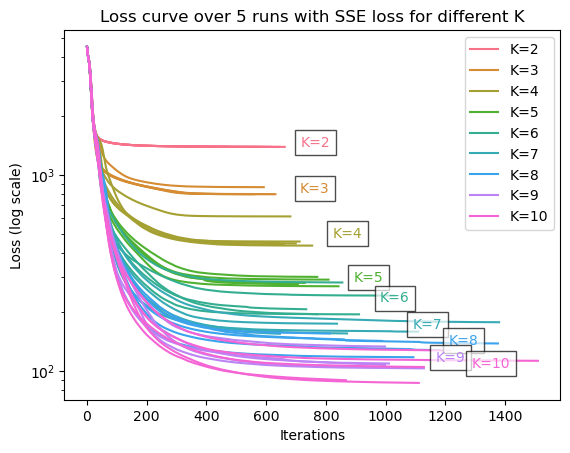

In [42]:
name = 'a1an'

with open(f'plot_data/loss_plots/loss_lists_{name}.pkl', 'rb') as f:
    loss_lists = pickle.load(f)

# log scale
for i, K in enumerate(K_list):
    plt.plot(loss_lists[i][0], color=colors[i], label=f'K={K}')
    last_elements = [sublist[-1] for sublist in loss_lists[i]]
    last_elementx = [len(sublist) for sublist in loss_lists[i]]
    plt.text(np.mean(last_elementx)+120, np.mean(last_elements), f'K={K}', color=colors[i], bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))
    for j in range(4):
        plt.plot(loss_lists[i][j+1], color=colors[i])
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.title('Loss curve over 5 runs with SSE loss for different K')
plt.savefig(f'data/loss_plots/loss_curve_{name}_log.svg', format='svg')
plt.show()

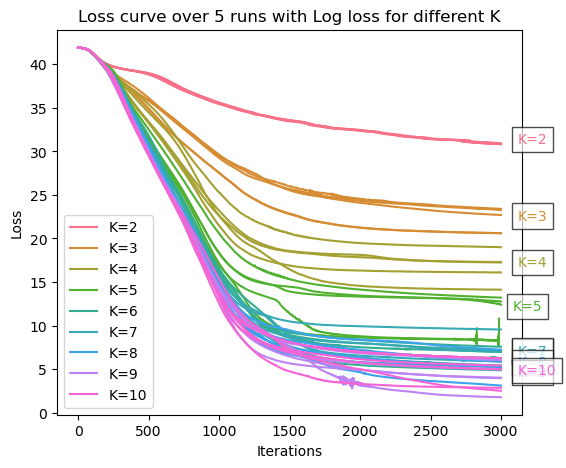

In [66]:
# use colors from seaborn
plt.figure(figsize=(6, 5))
K_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
colors = sns.color_palette("husl", len(K_list))

name = "a1al_5"

with open(f'plot_data/loss_plots/loss_lists_{name}.pkl', 'rb') as f:
    loss_lists = pickle.load(f)

for i, K in enumerate(K_list):
    plt.plot(loss_lists[i][0], color=colors[i], label=f'K={K}')
    last_elements = [sublist[-1] for sublist in loss_lists[i]]
    last_elementx = [len(sublist) for sublist in loss_lists[i]]
    plt.text(np.mean(last_elementx)+120, np.mean(last_elements), f'K={K}', color=colors[i], bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))
    for j in range(4):
        plt.plot(loss_lists[i][j+1], color=colors[i])
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss curve over 5 runs with Log loss for different K')
plt.savefig(f'data/loss_plots/loss_curve_{name}.svg', format='svg')
plt.show()

<Figure size 600x500 with 0 Axes>

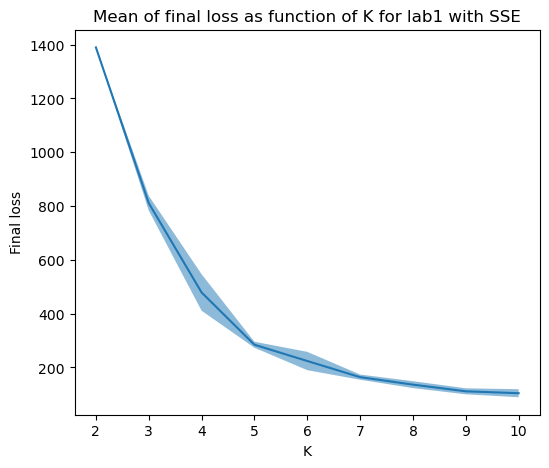

In [73]:
plt.figure(figsize=(6, 5))
K_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
colors = sns.color_palette("husl", len(K_list))

name = "11an"

with open(f'plot_data/loss_plots/loss_lists_{name}.pkl', 'rb') as f:
    loss_lists = pickle.load(f)

final_loss_mean_list = []
final_loss_std_list = []

for i, K in enumerate(K_list):
    last_elements = [sublist[-1] for sublist in loss_lists[i]]
    last_elementx = [len(sublist) for sublist in loss_lists[i]]
    final_loss_mean = np.mean(last_elements)
    final_loss_std = np.std(last_elements, ddof=4)/np.sqrt(5)
    
    final_loss_mean_list.append(final_loss_mean)
    final_loss_std_list.append(final_loss_std)

plt.figure(figsize=(6, 5))
plt.fill_between(K_list, np.array(final_loss_mean_list) - np.array(final_loss_std_list), np.array(final_loss_mean_list) + np.array(final_loss_std_list), alpha=0.5)
plt.plot(K_list, final_loss_mean_list)
plt.xlabel('K')
plt.ylabel('Final loss')
plt.title('Mean of final loss as function of K for lab1 with SSE')
plt.savefig(f'data/loss_plots/final_loss_{name}.svg', format='svg')
plt.show()